In [3]:
# --- Imports ---

# Qiskit main components
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Qiskit simulators
# We will use the Sampler primitive, which is the modern way to get counts
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler

# Qiskit visualization
from qiskit.visualization import plot_histogram

# Helper libraries
import numpy as np
from math import pi
import matplotlib.pyplot as plt

# Lab 2: Grover's Algorithm - Quantum Search

Welcome to your second lab! In the previous lab, you mastered single-qubit gates, multi-qubit gates, and the concept of entanglement. Now, you'll combine all those skills to build one of the most famous and powerful quantum algorithms: **Grover's Algorithm for Unstructured Search**.

Our goal is to build a quantum circuit that can find a "marked item" in an unordered list quadratically faster than any possible classical computer.

## The Problem: Unstructured vs. Structured Search

Imagine you have a massive telephone directory with $N$ entries.

**1. Structured Search (The "Easy" Problem)**
If you have a *name* (e.g., "Smith, John") and you want to find their *phone number*, the list is **structured**. It's sorted alphabetically. You don't need to check every name one-by-one (which would take $O(N)$ time).

Instead, you can use **Binary Search**:
1.  Open the book to the exact middle ("Miller,...").
2.  "Smith" comes after "Miller", so you *throw away the entire first half of the book*.
3.  You repeat this, cutting the remaining problem in half with every single check.

Because of this *structure* (sorting), you can find the name in $O(\log N)$ steps. This is incredibly fast.

**2. Unstructured Search (The "Hard" Problem)**
Now, imagine you have a *phone number* and you want to find the *name*. The directory is sorted by name, not by number. For your query, the list is completely **unstructured**.

You have no choice but to start at page 1 and check every single entry ($N$ of them) until you find the matching number. This "brute-force" search takes $O(N)$ time. This is the best any classical computer can do.

**The Quantum Promise**
Grover's algorithm tackles this *unstructured* problem. It provides a "quadratic speed-up," finding the marked item in only **$O(\sqrt{N})$** steps.

## Defining the Quantum Search Problem

We will formalise this problem using a "quantum black box," or **Oracle**.

Let's say we have $N=2^n$ possible items, where $n$ is the number of qubits. We can label each item with a computational basis state, like $|000\rangle, |001\rangle, \dots, |111\rangle$.

We are looking for one (or more) "marked items," which we'll call **solutions**.

The Oracle is a function $f(x)$ such that:
* $f(x) = 0$ if $|x\rangle$ is a "non-solution".
* $f(x) = 1$ if $|x\rangle$ is a "solution".

Our goal is to find an $x$ for which $f(x)=1$.

For this lab, we'll start with the **Unique Search** problem: we are promised that there is *exactly one* solution in the list.

## The Two "Tricks" of Grover's Algorithm

At a high level, Grover's algorithm is surprisingly simple. It just repeats two steps over and over:

1.  **The Oracle (Phase Flip):** We use a special circuit that "marks" the solution by flipping its phase (i.e., multiplying its amplitude by -1).
    * $|x_{\text{solution}}\rangle \rightarrow -|x_{\text{solution}}\rangle$
    * $|x_{\text{other}}\rangle \rightarrow |x_{\text{other}}\rangle$

2.  **The Diffuser (Amplitude Amplification):** We apply a clever circuit that "inverts the state about the average". This has the magical effect of taking the negatively-flipped amplitude and making it *much larger*, while shrinking all other amplitudes.

We start by putting all qubits in a uniform superposition (the $|u\rangle = H^{\otimes n} |0\rangle$ state), so every item has the same small amplitude.

Then we repeat: **"Flip, Amplify, Flip, Amplify..."**

Each time, the amplitude of the correct answer grows, and all others shrink. After about $O(\sqrt{N})$ steps, the amplitude of the solution is so large that when we measure, we are almost guaranteed to get the right answer.

## Step 1: The Oracle ($Z_f$)

Our Oracle $Z_f$ must perform the mapping: $|x\rangle \to (-1)^{f(x)} |x\rangle$.

How do we build this in Qiskit? We use a technique you might have heard of: **phase kickback**.
1.  We first build a "standard" oracle $U_f$ that flips an ancilla qubit:
    $U_f |x\rangle|q\rangle = |x\rangle|q \oplus f(x)\rangle$
2.  We prepare this ancilla qubit `q` in the state $|-\rangle = H|1\rangle$.
3.  Now, let's see what happens:
    * If $f(x)=0$: $U_f |x\rangle|-\rangle = |x\rangle|0 \oplus -\rangle = |x\rangle|-\rangle$. (Nothing happens).
    * If $f(x)=1$: $U_f |x\rangle|-\rangle = |x\rangle|1 \oplus -\rangle = |x\rangle(-|-\rangle) = -|x\rangle|-\rangle$.

The negative phase gets "kicked back" onto the input qubits *only* if $f(x)=1$. This is exactly the $Z_f$ oracle we need!

(This is the circuit from `08-Grover-algorithm.pdf`, Page 4).

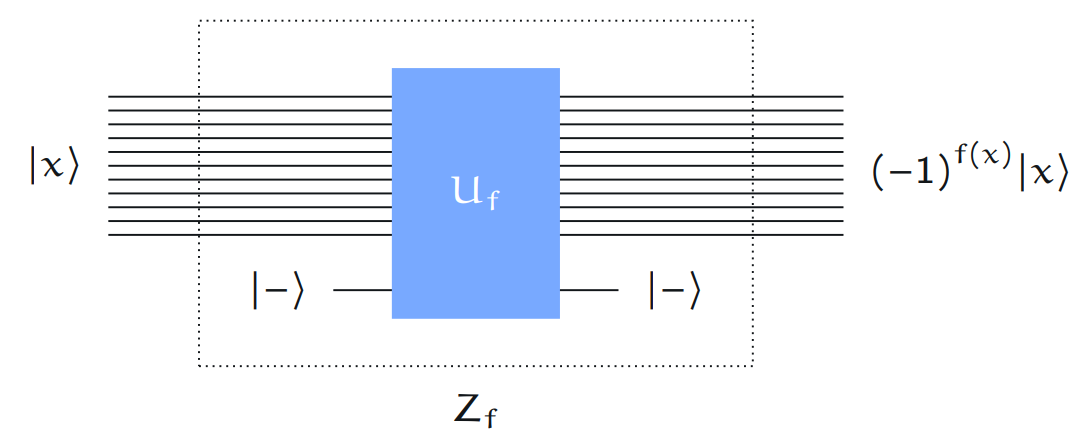

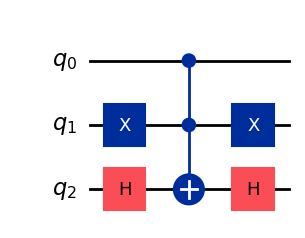

In [13]:
# --- Grover: Oracle built without qc.mcz/mcp ---
# We implement MCZ manually via the identity:  MCZ(controls, t) = H(t) · MCX(controls, t) · H(t)

from math import pi
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate  # used for a robust MCX fallback

def _apply_mcx(qc: QuantumCircuit, controls, target):
    """Apply a multi-controlled X robustly across Qiskit versions."""
    try:
        qc.mcx(controls, target)
    except AttributeError:
        # Fallback: construct a controlled-X with k controls and append it
        mcx_gate = XGate().control(len(controls))
        qc.append(mcx_gate, list(controls) + [target])

def _apply_mcz_manual(qc: QuantumCircuit, controls, target):
    """MCZ via H–MCX–H so we don't rely on qc.mcz or qc.mcp."""
    qc.h(target)
    _apply_mcx(qc, controls, target)
    qc.h(target)

def build_oracle(n: int, secret_state: str) -> QuantumCircuit:
    """
    Phase-flip oracle that flips the sign of |secret_state>.
    Qubit order is little-endian: the RIGHTMOST bit of 'secret_state' is qubit 0.
    """
    qc = QuantumCircuit(n, name=f"Oracle('{secret_state}')")

    # Bits that are '0' in the secret string (we flip them to map |secret> -> |11..1| before MCZ)
    zero_indices = [i for i, bit in enumerate(reversed(secret_state)) if bit == '0']

    ## ---- TODOs (read-only prompts for students) ----
    # 1) Apply X to each qubit whose secret bit is '0'.
    # 2) Apply an MCZ with controls = [0..n-2], target = n-1 (use the H–MCX–H trick).
    # 3) Uncompute the X from step (1).
    # (Implementations below in the SOLUTION block.)
    # -------------------------------------------------

    # --- SOLUTION (executed) ---
    if zero_indices:
        qc.x(zero_indices)                         # Step 1

    controls = list(range(n - 1))
    target   = n - 1
    _apply_mcz_manual(qc, controls, target)       # Step 2

    if zero_indices:
        qc.x(zero_indices)                         # Step 3
    # --- END SOLUTION ---

    return qc

# (Optional) Quick sanity check:
oracle_demo = build_oracle(3, "101")
display(oracle_demo.draw('mpl'))


## Step 2: The Diffuser (Inversion About the Mean)

This is the second "trick" and the real heart of the amplification. As the `analysis.ipynb` notebook shows, this operation is a **reflection** about the uniform superposition state $|u\rangle = H^{\otimes n}|0^n\rangle$.

We can build this reflection, $D$, using the *exact same logic* as the oracle!
The diffuser $D$ is just an oracle that *marks the $|00\dots0\rangle$ state*, and then wraps itself in $H$ gates.

$D = H^{\otimes n} \cdot Z_{OR} \cdot H^{\otimes n}$

Where $Z_{OR}$ is an oracle that flips the phase of every state *except* $|00\dots0\rangle$.
(This is the circuit from `08-Grover-algorithm.pdf`, Page 6).

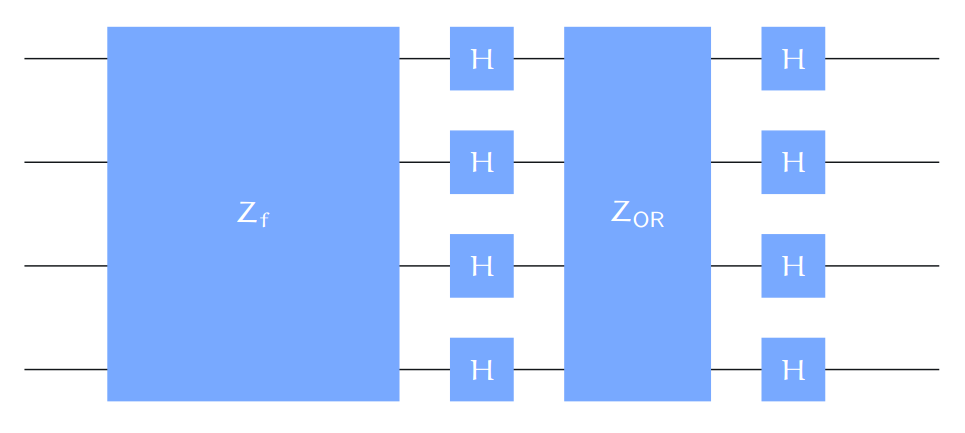

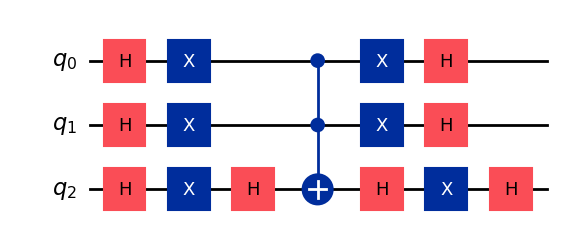

In [14]:
# --- Grover: Diffuser built without qc.mcz/mcp ---
# The standard n-qubit diffuser is: H^{⊗n} · Z_oracle(|0…0>) · H^{⊗n}
# We implement Z_oracle(|0…0>) by:  X^{⊗n} · MCZ(all-ones) · X^{⊗n}, with MCZ = H–MCX–H.

from qiskit import QuantumCircuit

def build_diffuser(n: int) -> QuantumCircuit:
    """Grover diffuser (inversion about the mean) for n qubits."""
    qc = QuantumCircuit(n, name="Diffuser")

    ## ---- TODOs (read-only prompts for students) ----
    # 1) Apply H to all qubits.
    # 2) Implement Z_oracle(|0…0>) as:
    #    a) X on all qubits,
    #    b) MCZ with controls=[0..n-2], target=n-1 (again H–MCX–H),
    #    c) X on all qubits.
    # 3) Apply H to all qubits again.
    # (Implementations below in the SOLUTION block.)
    # -------------------------------------------------

    # --- SOLUTION (executed) ---
    qc.h(range(n))                      # Step 1

    qc.x(range(n))                      # Step 2a
    controls = list(range(n - 1))       # Step 2b
    target   = n - 1
    _apply_mcz_manual(qc, controls, target)
    qc.x(range(n))                      # Step 2c

    qc.h(range(n))                      # Step 3
    # --- END SOLUTION ---

    return qc

# (Optional) Quick sanity check:
diffuser_demo = build_diffuser(3)
display(diffuser_demo.draw('mpl'))


## Step 3: Putting It All Together

Now we combine the pieces. The full algorithm is:
1.  **Initialise:** Apply $H^{\otimes n}$ to the $|0\dots0\rangle$ state to create the uniform superposition $|u\rangle$.
2.  **Iterate:** Repeat the following $t$ times:
    a. Apply the **Oracle**
    b. Apply the **Diffuser**
3.  **Measure:** Measure all qubits.

**How many iterations $t$?**
As shown in the `number-of-iterations.ipynb` notebook and PDF (Page 23), the optimal number of iterations $t$ for a *unique* solution in $N$ items is:
$$
t = \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rfloor
$$

Searching 8 items. Will use 2 Grover iteration(s).

--- Full Grover Circuit ---


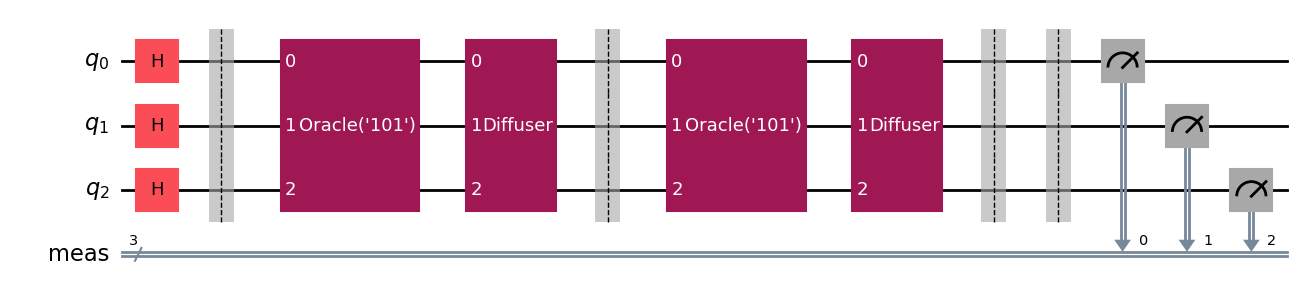


--- Running Simulation ---

--- Results ---


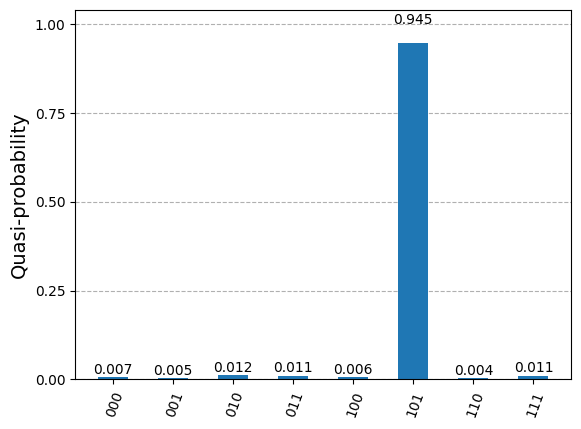

In [18]:
# --- Grover: Full algorithm assembly and sampling on a simulator ---

import numpy as np
from qiskit.visualization import plot_histogram

# Backends / primitives (robust imports across versions)
try:
    from qiskit_aer import AerSimulator
except Exception:
    AerSimulator = None

try:
    # If available, prefer AerSampler for speed and reproducibility
    from qiskit_aer.primitives import Sampler as AerSampler
    sampler = AerSampler()
except Exception:
    # Fallback to the reference Sampler
    from qiskit.primitives import Sampler
    sampler = Sampler()

# 1) Problem definition
n_qubits = 3
N = 2**n_qubits
secret_state = "101"  # target item

# 2) Optimal number of Grover iterations
t = int(np.floor(np.pi/4 * np.sqrt(N)))
print(f"Searching {N} items. Will use {t} Grover iteration(s).")

# 3) Get building blocks as gates
oracle_gate   = build_oracle(n_qubits, secret_state).to_gate()
diffuser_gate = build_diffuser(n_qubits).to_gate()

# 4) Build the full circuit with TODOs
from qiskit import QuantumCircuit
qc = QuantumCircuit(n_qubits)

## ---- TODOs (read-only prompts for students) ----
# 1) Prepare uniform superposition |u> with H on all qubits.
#    (Optional) add a barrier.
# 2) Repeat t times:
#      - Apply the Oracle gate
#      - Apply the Diffuser gate
#      - (Optional) barrier
# 3) Measure all qubits at the end.
# (Implementation below in the SOLUTION block.)
# -------------------------------------------------

# --- SOLUTION (executed) ---
qc_run = QuantumCircuit(n_qubits)
qc_run.h(range(n_qubits))              # Step 1
qc_run.barrier()

for _ in range(t):                     # Step 2
    qc_run.append(oracle_gate,   range(n_qubits))
    qc_run.append(diffuser_gate, range(n_qubits))
    qc_run.barrier()

qc_run.measure_all()                   # Step 3
# --- END SOLUTION ---

print("\n--- Full Grover Circuit ---")
display(qc_run.draw('mpl'))

# 5) Run on a sampler (1024 shots) and visualize the distribution
print("\n--- Running Simulation ---")
job = sampler.run(qc_run, shots=1024)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

print("\n--- Results ---")
display(plot_histogram(counts))

## Analysis: How Did That Work? (The Geometry of Search)

If everything worked, your histogram shows a massive spike at `'101'`, our secret state. We successfully found the needle in the haystack!

This works because of a process called **Amplitude Amplification**. The geometry of this is the key to *why* it works.

### 1. The Big Question: Why a 2D Circle?

You're right to be curious: we have $N=8$ possible states, so we're working in an 8-dimensional complex Hilbert space. How can we *possibly* draw this on a 2D circle?

The answer is the "magic" of Grover's algorithm: **the entire algorithm lives in a tiny 2D slice (a plane) of that 8-dimensional space.**

To see this, we can cleverly define two new basis vectors:

* **$|A_1\rangle$ (The "Solution" Vector):** A vector that represents a uniform superposition of all the "marked" or "solution" states. In our simple case, there is only one solution, $|101\rangle$. So, for us:
    $|A_1\rangle = |101\rangle$

* **$|A_0\rangle$ (The "Non-Solution" Vector):** A vector that represents a uniform superposition of *all other* states. For us, this is a superposition of the 7 non-solution states:
    $|A_0\rangle = \frac{1}{\sqrt{7}} \left( |000\rangle + |001\rangle + \dots + |100\rangle + |110\rangle + |111\rangle \right)$

Because **every** operation in the algorithm (the start, the oracle, and the diffuser) can be written *only* in terms of these two vectors, we can ignore the other dimensions and just analyze this 2D plane.

Our starting state, the uniform superposition $|u\rangle$, is also in this plane:
$|u\rangle = \frac{1}{\sqrt{8}} \sum_{x} |x\rangle = \sqrt{\frac{7}{8}} |A_0\rangle + \sqrt{\frac{1}{8}} |A_1\rangle$

This $|u\rangle$ state is our starting vector. It's *very* close to the $|A_0\rangle$ axis (since $\sqrt{7/8} \approx 0.935$) and far from the $|A_1\rangle$ solution. Our goal is to **rotate** this vector to be as close to $|A_1\rangle$ as possible.

### 2. The Grover Iteration: A Pair of Reflections

The Grover iteration $G = D \cdot Z_f$ is a composition of two geometric reflections.

**Step 1: The Oracle ($Z_f$) = Reflection 1**
The Oracle performs a **reflection across the $|A_0\rangle$ axis ($L_1$)**.
It flips the phase of the solution state:
* $Z_f |A_0\rangle = |A_0\rangle$ (doesn't touch non-solutions)
* $Z_f |A_1\rangle = -|A_1\rangle$ (flips the solution)
Geometrically, it takes our state $|\psi\rangle = a|A_0\rangle + b|A_1\rangle$ and flips the part of it that's in the "solution" direction.

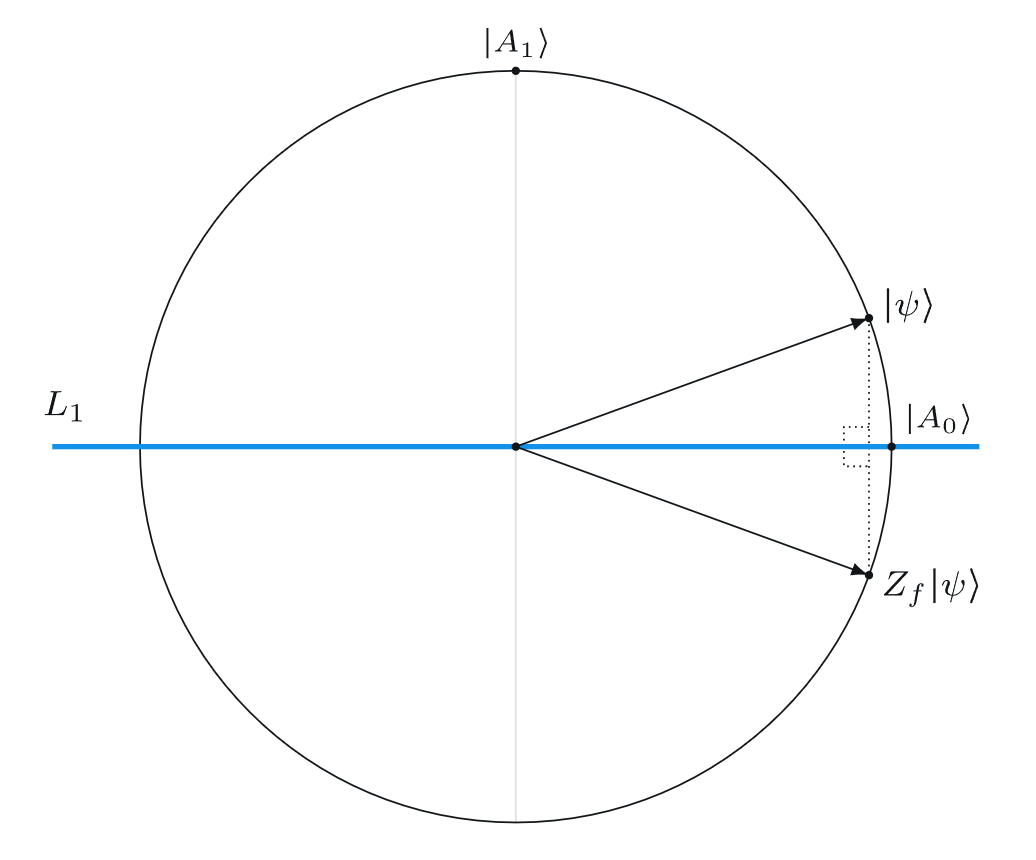

**Step 2: The Diffuser ($D$) = Reflection 2**

The Diffuser performs a **reflection across the initial state axis, $|u\rangle$ ($L_2$)**.
This operation "inverts about the mean." It takes every state's amplitude, computes the average, and flips it to the other side of that average. The geometric result is a perfect reflection across the line $L_2$.

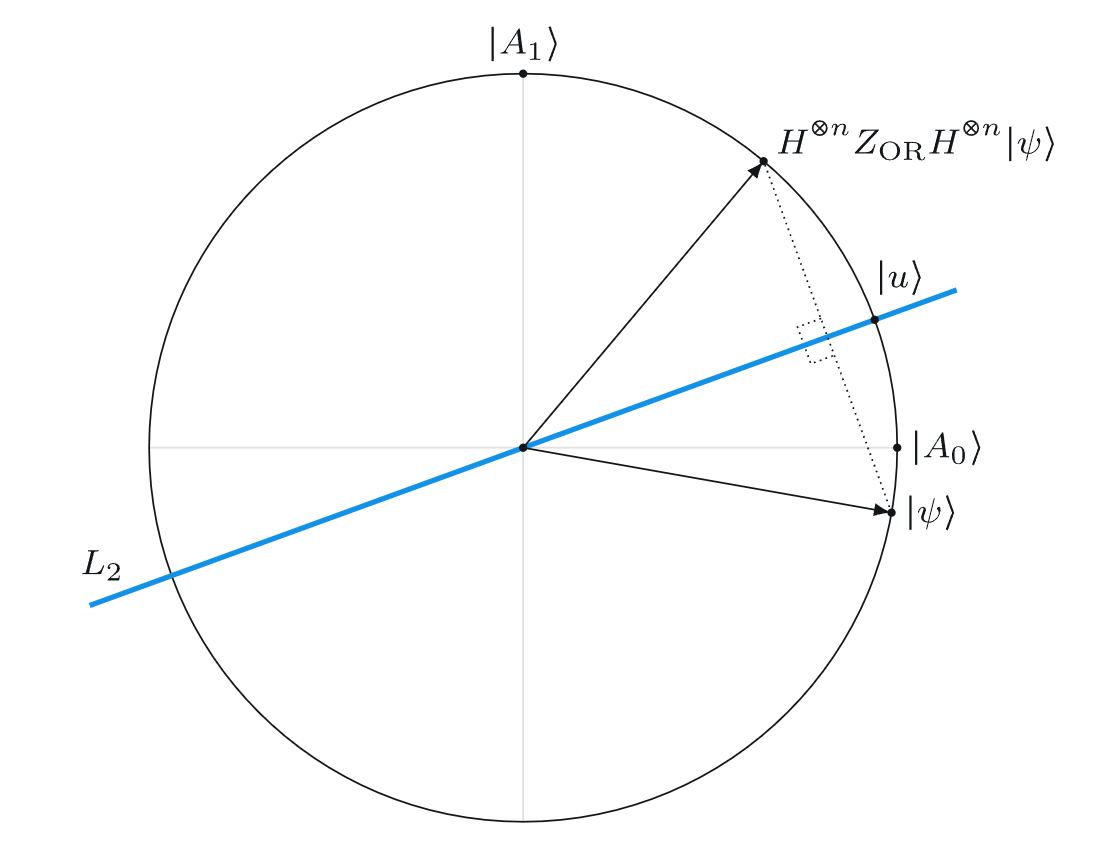


### 3. The Full Step: Reflections = Rotation

Here is the key insight: **A reflection of a reflection is a rotation.**

1.  We start at $|u\rangle$.
2.  The **Oracle** reflects us across $|A_0\rangle$ to the position $Z_f |u\rangle$.
3.  The **Diffuser** then reflects that new state across the $|u\rangle$ axis.

This *pulls* the state vector past the $|u\rangle$ axis and rotates it closer to the solution $|A_1\rangle$.

The angle of this rotation is $2\theta$, where $\theta$ is the tiny angle between our starting state $|u\rangle$ and the $|A_0\rangle$ axis. By repeating this "Flip, Amplify" (Reflect, Reflect) step, we keep rotating our state vector by $2\theta$ until it points right at our solution, $|A_1\rangle$.

After $t \approx \frac{\pi}{4\theta} \approx \frac{\pi}{4}\sqrt{N}$ steps, we measure, and with near-certainty, the state collapses to the solution we were looking for.

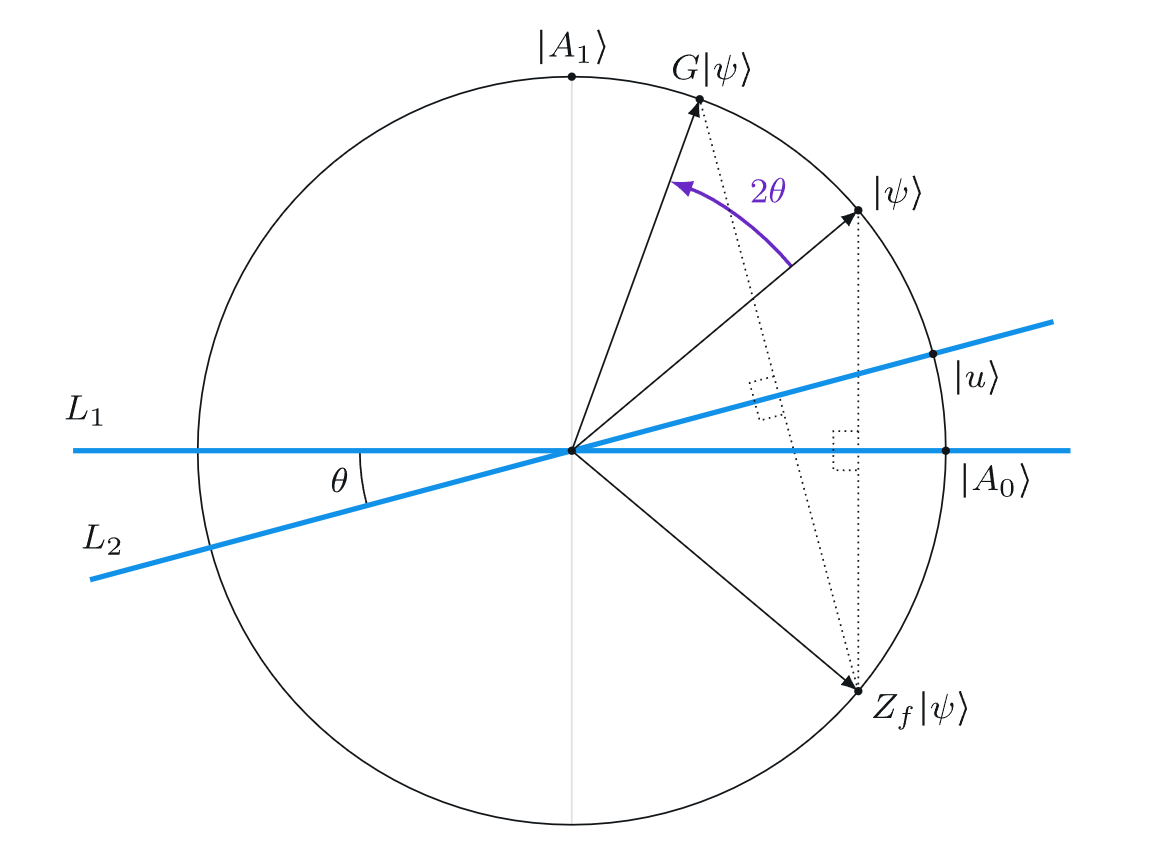

## Conclusion & Questions for Thought

You have successfully built a quantum algorithm that finds a marked item in an unstructured list, demonstrating a **quadratic speed-up** over the best possible classical algorithm ($O(\sqrt{N})$ vs. $O(N)$).

This technique, more generally called **Amplitude Amplification**, is a core tool in quantum computing and is used as a subroutine in many other algorithms.

---

### Questions for Thought

1.  **Overshooting the Mark:** What do you think would happen if you run *too many* iterations? Try modifying the code to run `t = 5` iterations (instead of the optimal $t=2$) for $N=8$. What do you see? (Hint: The state vector will *rotate past* the solution!)

2.  **Multiple Solutions:** What if there are *multiple* solutions (e.g., $s=2$ or $s=3$)? The formula for the optimal number of iterations becomes $t \approx O(\sqrt{N/s})$. Does the algorithm get faster or slower?

3.  **No Solutions:** What happens if there are *no* solutions? (i.e., $f(x)=0$ for all $x$). What does the Oracle $Z_f$ do? What does the Diffuser do? Will the algorithm ever find a "solution"?